In [134]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

import torchvision.transforms as tfs
from torch.utils.data import DataLoader

In [115]:
data_train = pd.read_csv('/content/mnist_train.csv')
data_test = pd.read_csv('/content/mnist_test.csv')

In [116]:
data = pd.DataFrame()
data = data.append(data_train)
data = data.append(data_test)

In [117]:
data = data.sample(frac=1).reset_index()
data.drop(columns={'index'})

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69996,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69998,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [118]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform=None):
        self.X = torch.tensor(X.values)
        self.y = torch.tensor(y.values) 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

def create_datasets(data, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    num_train = int(len(data)*p_train)
    num_val = int(len(data)*p_val)
    num_test = int(len(data)*p_test)

    data_train = data[:num_train].drop(columns='index')
    data_valid = data[num_train:num_train+num_val].drop(columns='index')
    data_test = data[-num_test:].drop(columns='index')

    X_train, y_train = data_train.drop(columns='label'), data_train['label']
    X_val, y_val = data_valid.drop(columns='label'), data_valid['label']
    X_test, y_test = data_test.drop(columns='label'), data_test['label']

    data_train = dataset_class(X_train, y_train)
    data_valid = dataset_class(X_val, y_val)
    data_test = dataset_class(X_test, y_test)

    return data_train, data_valid, data_test


In [119]:
data_train, data_valid, data_test = create_datasets(data, Dataset)

In [120]:
train_dataloader = DataLoader(data_train, 
                              batch_size=64, 
                              drop_last=True)
valid_dataloader = DataLoader(data_valid, 
                              batch_size=64,
                              drop_last=True)
test_dataloader = DataLoader(data_test, 
                              batch_size=64, 
                             drop_last=True)

In [121]:
loaders = {'train': train_dataloader, 'valid': valid_dataloader}

In [122]:
import torch
from torch import nn
from torch.nn import functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        nn.Flatten()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.type(torch.float32)
        x = self.fc1(x)
        x = F.elu(x)
        x = self.fc2(x)
        x = F.elu(x)
        x = self.fc3(x)

        return x

net = Net()
net

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [123]:
# hyper parameters
max_epoch = 10

# loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

# GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

In [124]:
accuracy = {'train': [], 'valid': []}

for epoch in range(max_epoch):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == 'train':
                net.train()
                output = net.forward(x_batch)
                #y_batch = y_batch.type(torch.LongTensor)
                loss = criterion(output, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            else:
                net.eval()
                with torch.no_grad():
                    output = net.forward(x_batch)
            preds = output.argmax(-1)
            all = 64
            correct = torch.tensor(y_batch[y_batch==preds].size()) 
            epoch_correct += correct.item()
            epoch_all += all
        if k == 'train':
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8985535714285714
Loader: valid. Accuracy: 0.9442373853211009
Epoch: 2
Loader: train. Accuracy: 0.96
Loader: valid. Accuracy: 0.9542717889908257
Epoch: 3
Loader: train. Accuracy: 0.9738035714285714
Loader: valid. Accuracy: 0.9618692660550459
Epoch: 4
Loader: train. Accuracy: 0.9789464285714286
Loader: valid. Accuracy: 0.9618692660550459
Epoch: 5
Loader: train. Accuracy: 0.9805714285714285
Loader: valid. Accuracy: 0.9643061926605505
Epoch: 6
Loader: train. Accuracy: 0.9840357142857142
Loader: valid. Accuracy: 0.9634461009174312
Epoch: 7
Loader: train. Accuracy: 0.9871607142857143
Loader: valid. Accuracy: 0.9668864678899083
Epoch: 8
Loader: train. Accuracy: 0.9878928571428571
Loader: valid. Accuracy: 0.9686066513761468
Epoch: 9
Loader: train. Accuracy: 0.9896428571428572
Loader: valid. Accuracy: 0.9686066513761468
Epoch: 10
Loader: train. Accuracy: 0.9882142857142857
Loader: valid. Accuracy: 0.9706135321100917


In [145]:
images_indexes = np.random.randint(data_test.__len__(), size = 10)

Prediction:  tensor(1)
Label:  tensor(1)


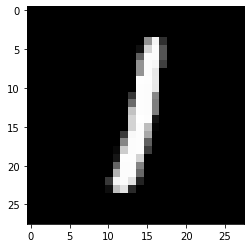

Prediction:  tensor(8)
Label:  tensor(8)


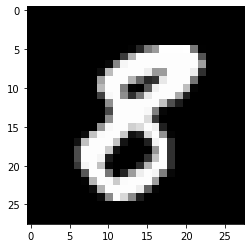

Prediction:  tensor(6)
Label:  tensor(6)


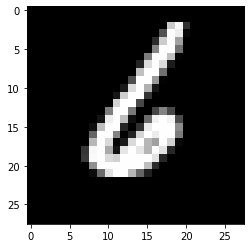

Prediction:  tensor(3)
Label:  tensor(3)


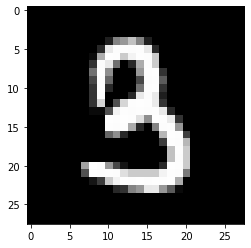

Prediction:  tensor(7)
Label:  tensor(7)


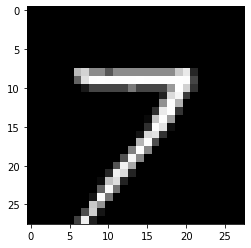

Prediction:  tensor(0)
Label:  tensor(0)


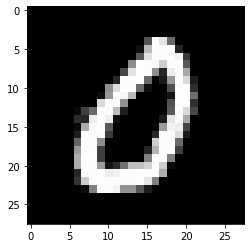

Prediction:  tensor(6)
Label:  tensor(6)


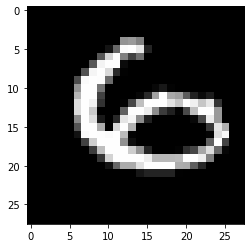

Prediction:  tensor(1)
Label:  tensor(1)


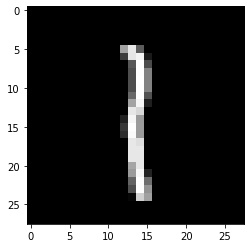

Prediction:  tensor(1)
Label:  tensor(1)


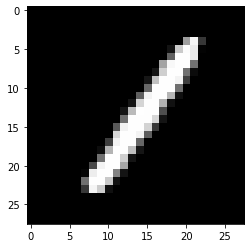

Prediction:  tensor(2)
Label:  tensor(2)


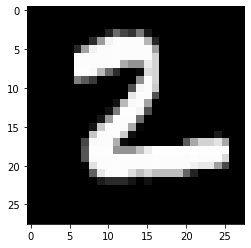

In [146]:
for index in images_indexes:
    image, label = data_test[index][0], data_test[index][1]
    current_image = image
    prediction = net.forward(image).argmax()
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()